In [1]:
## 元ファイルは, tag_percentage_nishimoto.ipynb

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colorbar as mcolorbar
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import itertools
from itertools import combinations
from collections import Counter
from tqdm import tqdm

import networkx as nx
import igraph as ig
import leidenalg

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

## 読み込みはここから

In [2]:
tag_color_map = {
    "k-pop": "#e41a1c",        # 赤
    "korean_pop": "#b22222",    # 濃い赤（Firebrick）
    "j-pop": "#377eb8",        # 青
    'pop': '#2ca02c',  # 鮮やか緑（指定通り）
    "rock": "#d62728",         # 濃い赤
    "rap": "#bcbd22",          # 黄土色
    "other": "#aaaaaa",        # グレー
    "anime": "#66c2a5",        # 水色1
    "j-rock": "#8da0cb",       # 水色2（違う色に変更）
    "soundtrack": "#a6d854",   # 黄緑
    "visual_kei": "#ffd92f",   # 黄色
    "boy_band": "#f46d43",    # 専用水色（明るいシアン）
    "girl_group": "#e78ac3",   # 桃色
    'Ambient':          '#a6cee3',  # 明るい水色
    'Pop':              '#2ca02c',  # 鮮やか緑（指定通り）
    'Punk':             '#fdbf6f',  # 明るいオレンジ
    'Rock':             '#d4a6c8',  # ラベンダー
    'rock':             '#d4a6c8',  # ラベンダー
    'Progressive Metal':'#ffff99',  # 薄黄色
    'Metalcore':        '#b2df8a',  # 明るい緑
    'Indie Rock':       '#fb9a99',  # ピンクレッド
    'Black Metal':      '#1f78b4',  # 濃めのブルー（明確に区別）
    'Rap':              '#bcbd22',  # 紫（やや濃いめ、Popと被らない）
    'Metal':            '#f0e442',  # イエローグリーン（目立つ）
}


In [3]:
import pickle

def save_pickle(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)


def load_pickle(path):
    with open(path, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
bar_data_top_other_kpop = load_pickle("./pickle_data/bar_data_top_other_kpop.pkl")
bar_data_top_other_jpop = load_pickle("./pickle_data/bar_data_top_other_jpop.pkl")

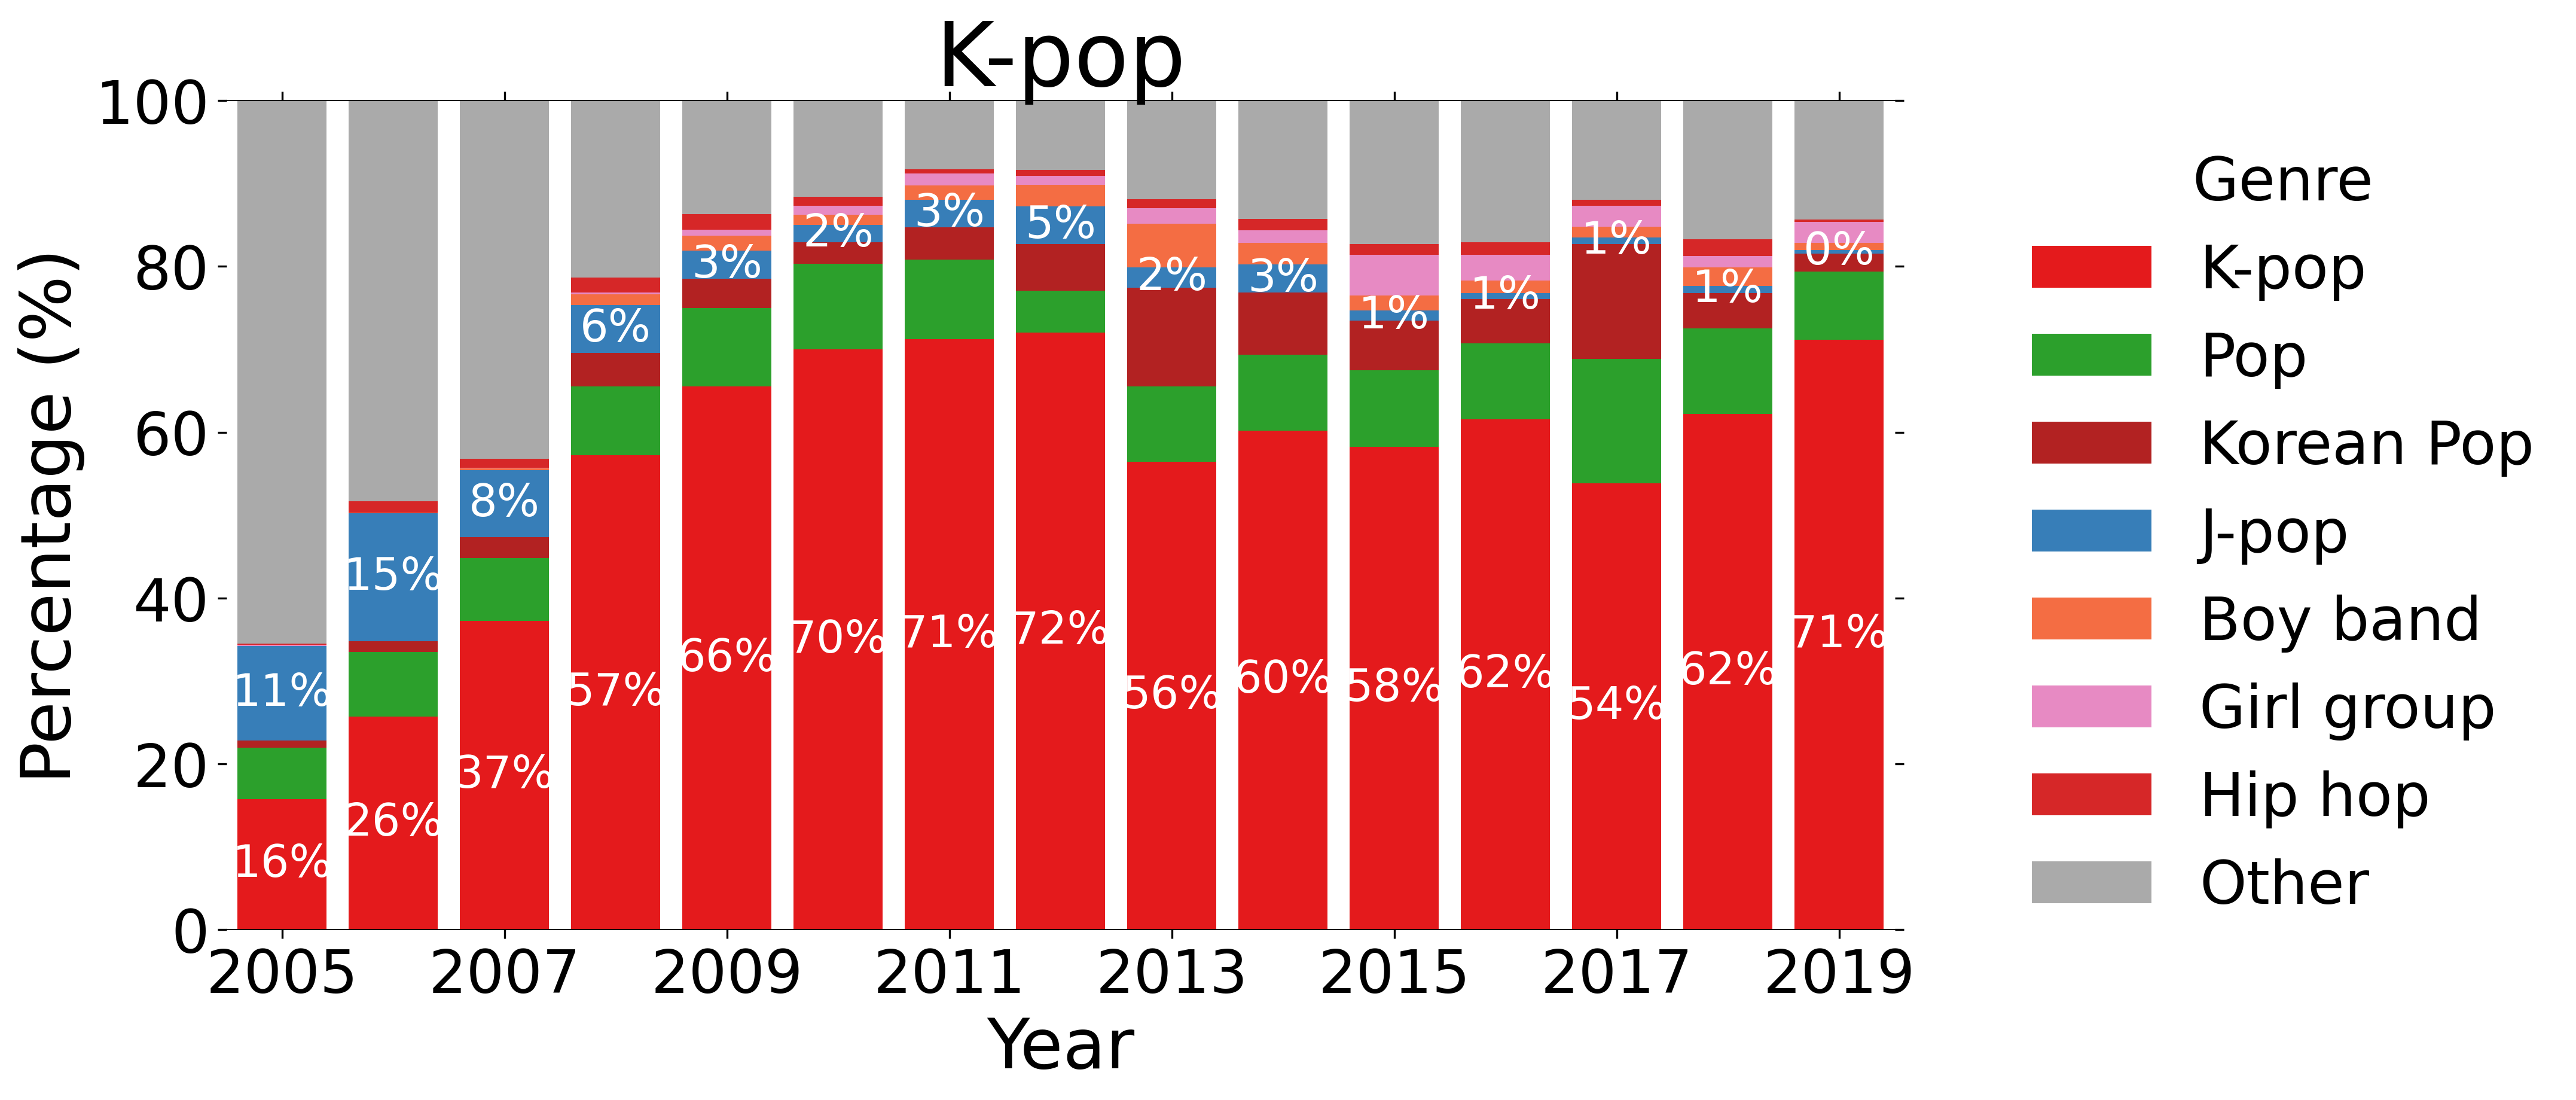

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

legend_rename_map = {
    "k-pop": "K-pop",
    "korean_pop": "Korean Pop",
    "j-pop": "J-pop",
    "pop": "Pop",
    "rock": "Rock",
    "rap": "Rap",
    "new_rave": "New Rave",
    "chillwave": "Chillwave",
    "trap": "Trap",
    "djent": "Djent",
    "boy_band": "Boy band",
    "girl_group": "Girl group",
    "other": "Other",
    "anime": "Anime",
    "visual_kei": "Visual kei",
    "soundtrack": "Soundtrack",
    "j-rock": "J-rock",
    "hip_hop" : "Hip hop"
    # ... 必要に応じて追加
}

# 上位表示するタグの件数（この値を変更することで、上位5, 6, 7, 8などを表示可能）
genre = "k-pop"
n_top = 7  # 例：5, 6, 7, 8 などに変更可能
highlight_tags = ['j-pop', 'k-pop']

# overall_counter_kpop から上位 n_top タグを抽出
top_tags_kpop = ['k-pop', 'pop', 'korean_pop', 'j-pop', 'boy_band', 'girl_group', 'hip_hop']
bar_labels_kpop = top_tags_kpop + ["other"]

# --- スタイルとフォント設定 ---
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 300
plt.rc('font', size=9)             # ベースフォント
plt.rc('axes', titlesize=20)       # タイトル
plt.rc('axes', labelsize=18)       # 軸ラベル
plt.rc('xtick', labelsize=16)       # 目盛
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=14)      # 凡例ラベル
plt.rc('lines', linewidth=1.2)     # 線の太さ

# 2005〜2019の年リスト（必要に応じて定義）
years = list(range(2005, 2020))

fig, ax2 = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(years))

# 各バーに対して指定色を適用
for idx, label in enumerate(bar_labels_kpop):
    values = [bar_data_top_other_kpop[year][idx] for year in years]

    # 凡例用ラベルを辞書で変換
    renamed_label = legend_rename_map.get(label.lower(), label)
    
    # 指定の色があれば使い、なければデフォルト（tab20）
    bar_color = tag_color_map.get(label.lower(), None)
    if bar_color is None:
        bar_color = plt.get_cmap("tab20")(idx % 20)  # フォールバック

    bars = ax2.bar(years, values, bottom=bottom, label=renamed_label, color=bar_color)

    # 特定ジャンルのみラベル表示
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.002 and label.lower() in highlight_tags:
            ax2.text(bar.get_x() + bar.get_width()/2, bottom[i] + height/2,
                     f"{height*100:.0f}%", ha='center', va='center',
                     fontsize=18, color='white')

    bottom += np.array(values)


ax2.set_title("K-pop", fontsize=36)
ax2.set_xlabel("Year", fontsize=28)
ax2.set_ylabel("Percentage (%)", fontsize=28)
ax2.set_ylim(0, 1)

# --- 目盛を 0–100% 表示に変更 ---
ax2.set_yticks(np.linspace(0, 1, 6))  # 0.0, 0.2, ..., 1.0
ax2.set_yticklabels(['0', '20', '40', '60', '80', '100'])

# --- 左右の軸線を非表示（目盛りは残す） ---
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(True)
ax2.tick_params(top=True, right=True, labelsize=24)

# --- 横軸を2005〜2019に固定 ---
ax2.set_xticks(years)
ax2.set_xticks(range(2005, 2021, 2))  # ← 2年ごとの目盛りに変更
ax2.set_xlim(2004.5, 2019.5)

# 凡例
ax2.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False,
           title_fontsize=24, fontsize=24)
# plt.tight_layout()
#plt.savefig("kpop_bar_only.pdf", dpi=300, bbox_inches='tight')
plt.show()

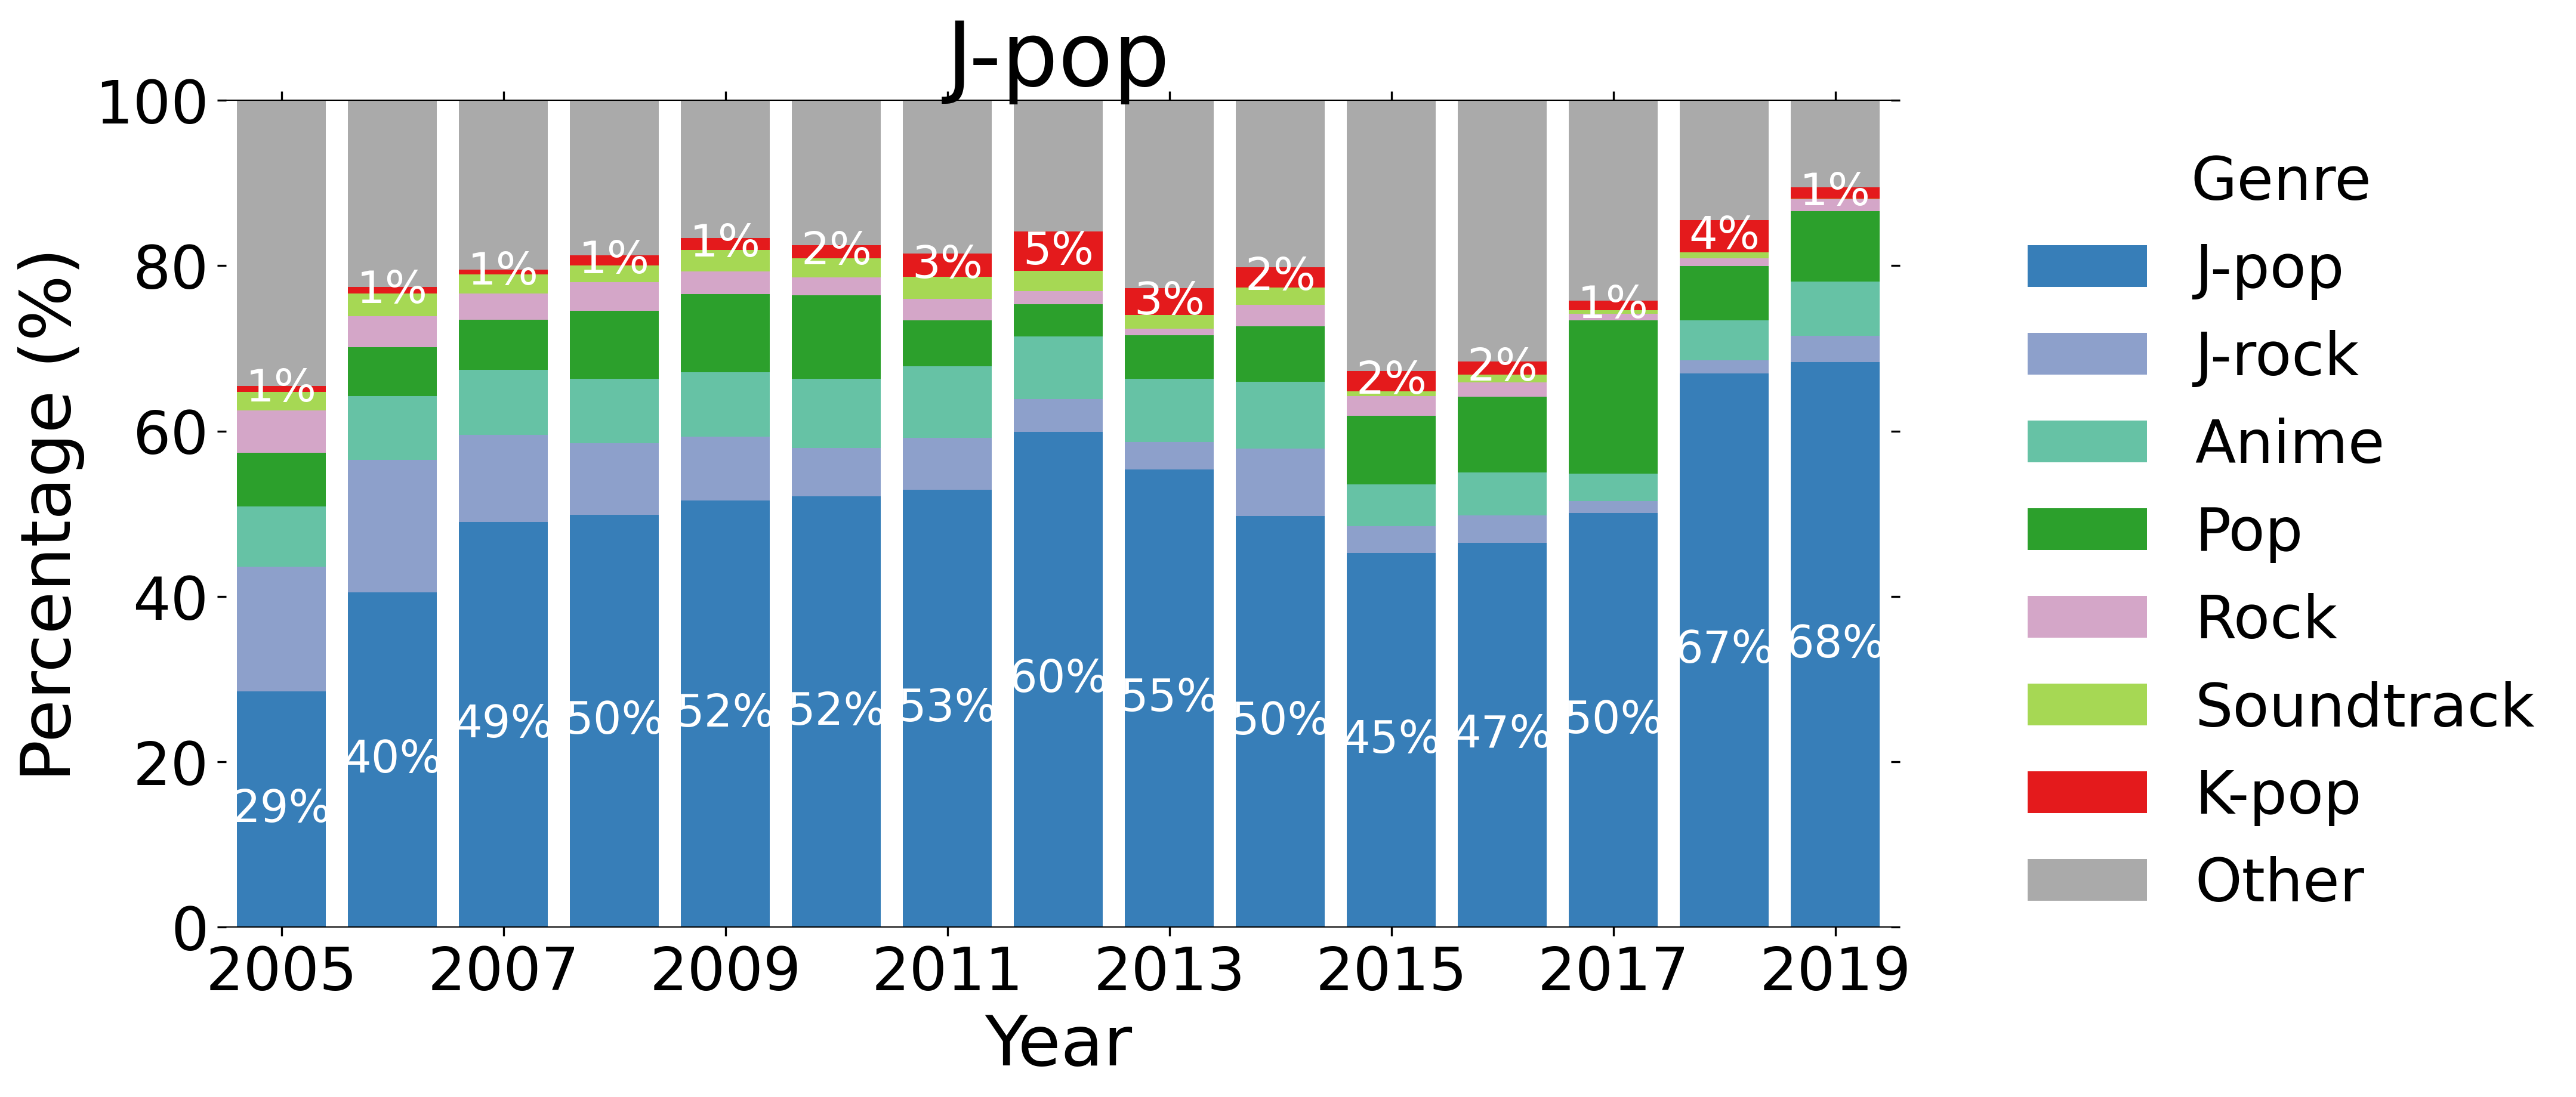

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

# ここでは既に per_year_counts_kpop, overall_counter_kpop, etc. がある前提
n_top = 7  # 表示する上位タグ数

# --- 凡例の名前変換用の辞書 ---
legend_rename_map = {
    "k-pop": "K-pop",
    "korean_pop": "Korean Pop",
    "j-pop": "J-pop",
    "pop": "Pop",
    "rock": "Rock",
    "rap": "Rap",
    "new_rave": "New Rave",
    "chillwave": "Chillwave",
    "trap": "Trap",
    "djent": "Djent",
    "boy_band": "Boy band",
    "girl_group": "Girl group",
    "other": "Other",
    "anime": "Anime",
    "visual_kei": "Visual kei",
    "soundtrack": "Soundtrack",
    "j-rock": "J-rock",
    # ... 必要に応じて追加
}

# overall_counter_kpop から上位 n_top タグを抽出
top_tags_jpop = ['j-pop', 'j-rock', 'anime', 'pop', 'rock', 'soundtrack', 'k-pop']

# 2005〜2019の年リスト
years = list(range(2005, 2020))

# 積み上げ用のデータを作成（上位 n_top タグ＋"other"）
"""
bar_data_top_other_jpop = {}
for year in years:
    counter = per_year_counts_jpop[year]
    total = sum(counter.values())
    top_counts = [counter.get(tag, 0) for tag in top_tags_jpop]
    sum_top = sum(top_counts)
    other = total - sum_top
    if total > 0:
        proportions = [cnt / total for cnt in top_counts] + [other / total]
    else:
        proportions = [0] * (len(top_tags_jpop) + 1)
    bar_data_top_other_jpop[year] = proportions
"""
bar_labels_jpop = top_tags_jpop + ["other"]

# --- スタイルとフォント設定 ---
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 300
plt.rc('font', size=9)             # ベースフォント
plt.rc('axes', titlesize=20)       # タイトル
plt.rc('axes', labelsize=18)       # 軸ラベル
plt.rc('xtick', labelsize=16)      # x目盛
plt.rc('ytick', labelsize=16)      # y目盛
plt.rc('legend', fontsize=14)      # 凡例ラベル
plt.rc('lines', linewidth=1.2)     # 線の太さ

# --- 棒グラフを描画 ---
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(years))

for idx, label in enumerate(bar_labels_jpop):
    values = [bar_data_top_other_jpop[year][idx] for year in years]
    
    # 凡例用ラベルを辞書で変換
    renamed_label = legend_rename_map.get(label.lower(), label)
    
    # 指定の色があれば使い、なければデフォルト（tab20）
    bar_color = tag_color_map.get(label.lower(), None)
    if bar_color is None:
        bar_color = plt.get_cmap("tab20")(idx % 20)

    # 棒グラフを描画
    bars = ax.bar(years, values, bottom=bottom, label=renamed_label, color=bar_color)

    # # -------- バー上に % 表示するロジック --------
    # # pop, k-pop, j-pop だけ 2% 超過時にラベルを表示
    # for i, bar in enumerate(bars):
    #     height = bar.get_height()  # バーの高さ＝割合(0～1)
    #     # pop, k-pop, j-pop のみ＆ 2%以上で表示
    #     if label.lower() in ["pop", "k-pop", "j-pop"] and height > 0.02:
    #         ax.text(
    #             bar.get_x() + bar.get_width() / 2,
    #             bottom[i] + height / 2,
    #             f"{height * 100:.0f}%",  # x.xx * 100 → パーセント
    #             ha='center',
    #             va='center',
    #             fontsize=12,
    #             color='black',
    #             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    #         )

    # bottom += np.array(values)

    # 特定ジャンルのみラベル表示
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.002 and label.lower() in ["k-pop", "j-pop"]:
            ax.text(bar.get_x() + bar.get_width()/2, bottom[i] + height/2,
                     f"{height*100:.0f}%", ha='center', va='center',
                     fontsize=18, color='white')

    bottom += np.array(values)

ax.set_title("J-pop", fontsize=36)
ax.set_xlabel("Year", fontsize=28)
ax.set_ylabel("Percentage (%)", fontsize=28)
ax.set_ylim(0, 1)

# 目盛を 0–100% 表示に変更
ax.set_yticks(np.linspace(0, 1, 6))  # 0.0, 0.2, ..., 1.0
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])

# 左右の軸線を非表示（目盛りは残す）
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.tick_params(top=True, right=True, labelsize=24)

# 横軸を2005〜2019に固定し、2年ごとに表示
ax.set_xticks(years)
ax.set_xticks(range(2005, 2021, 2))
ax.set_xlim(2004.5, 2019.5)

# 凡例
ax.legend(
    title="Genre",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    title_fontsize=24,
    fontsize=24
)
#plt.tight_layout() 
# PDF / EPS で保存（必要に応じて）
#plt.savefig("jpop_bar_only.pdf", dpi=300, bbox_inches='tight')
#plt.savefig("jpop_bar_only.eps", dpi=300, bbox_inches='tight')
plt.show()

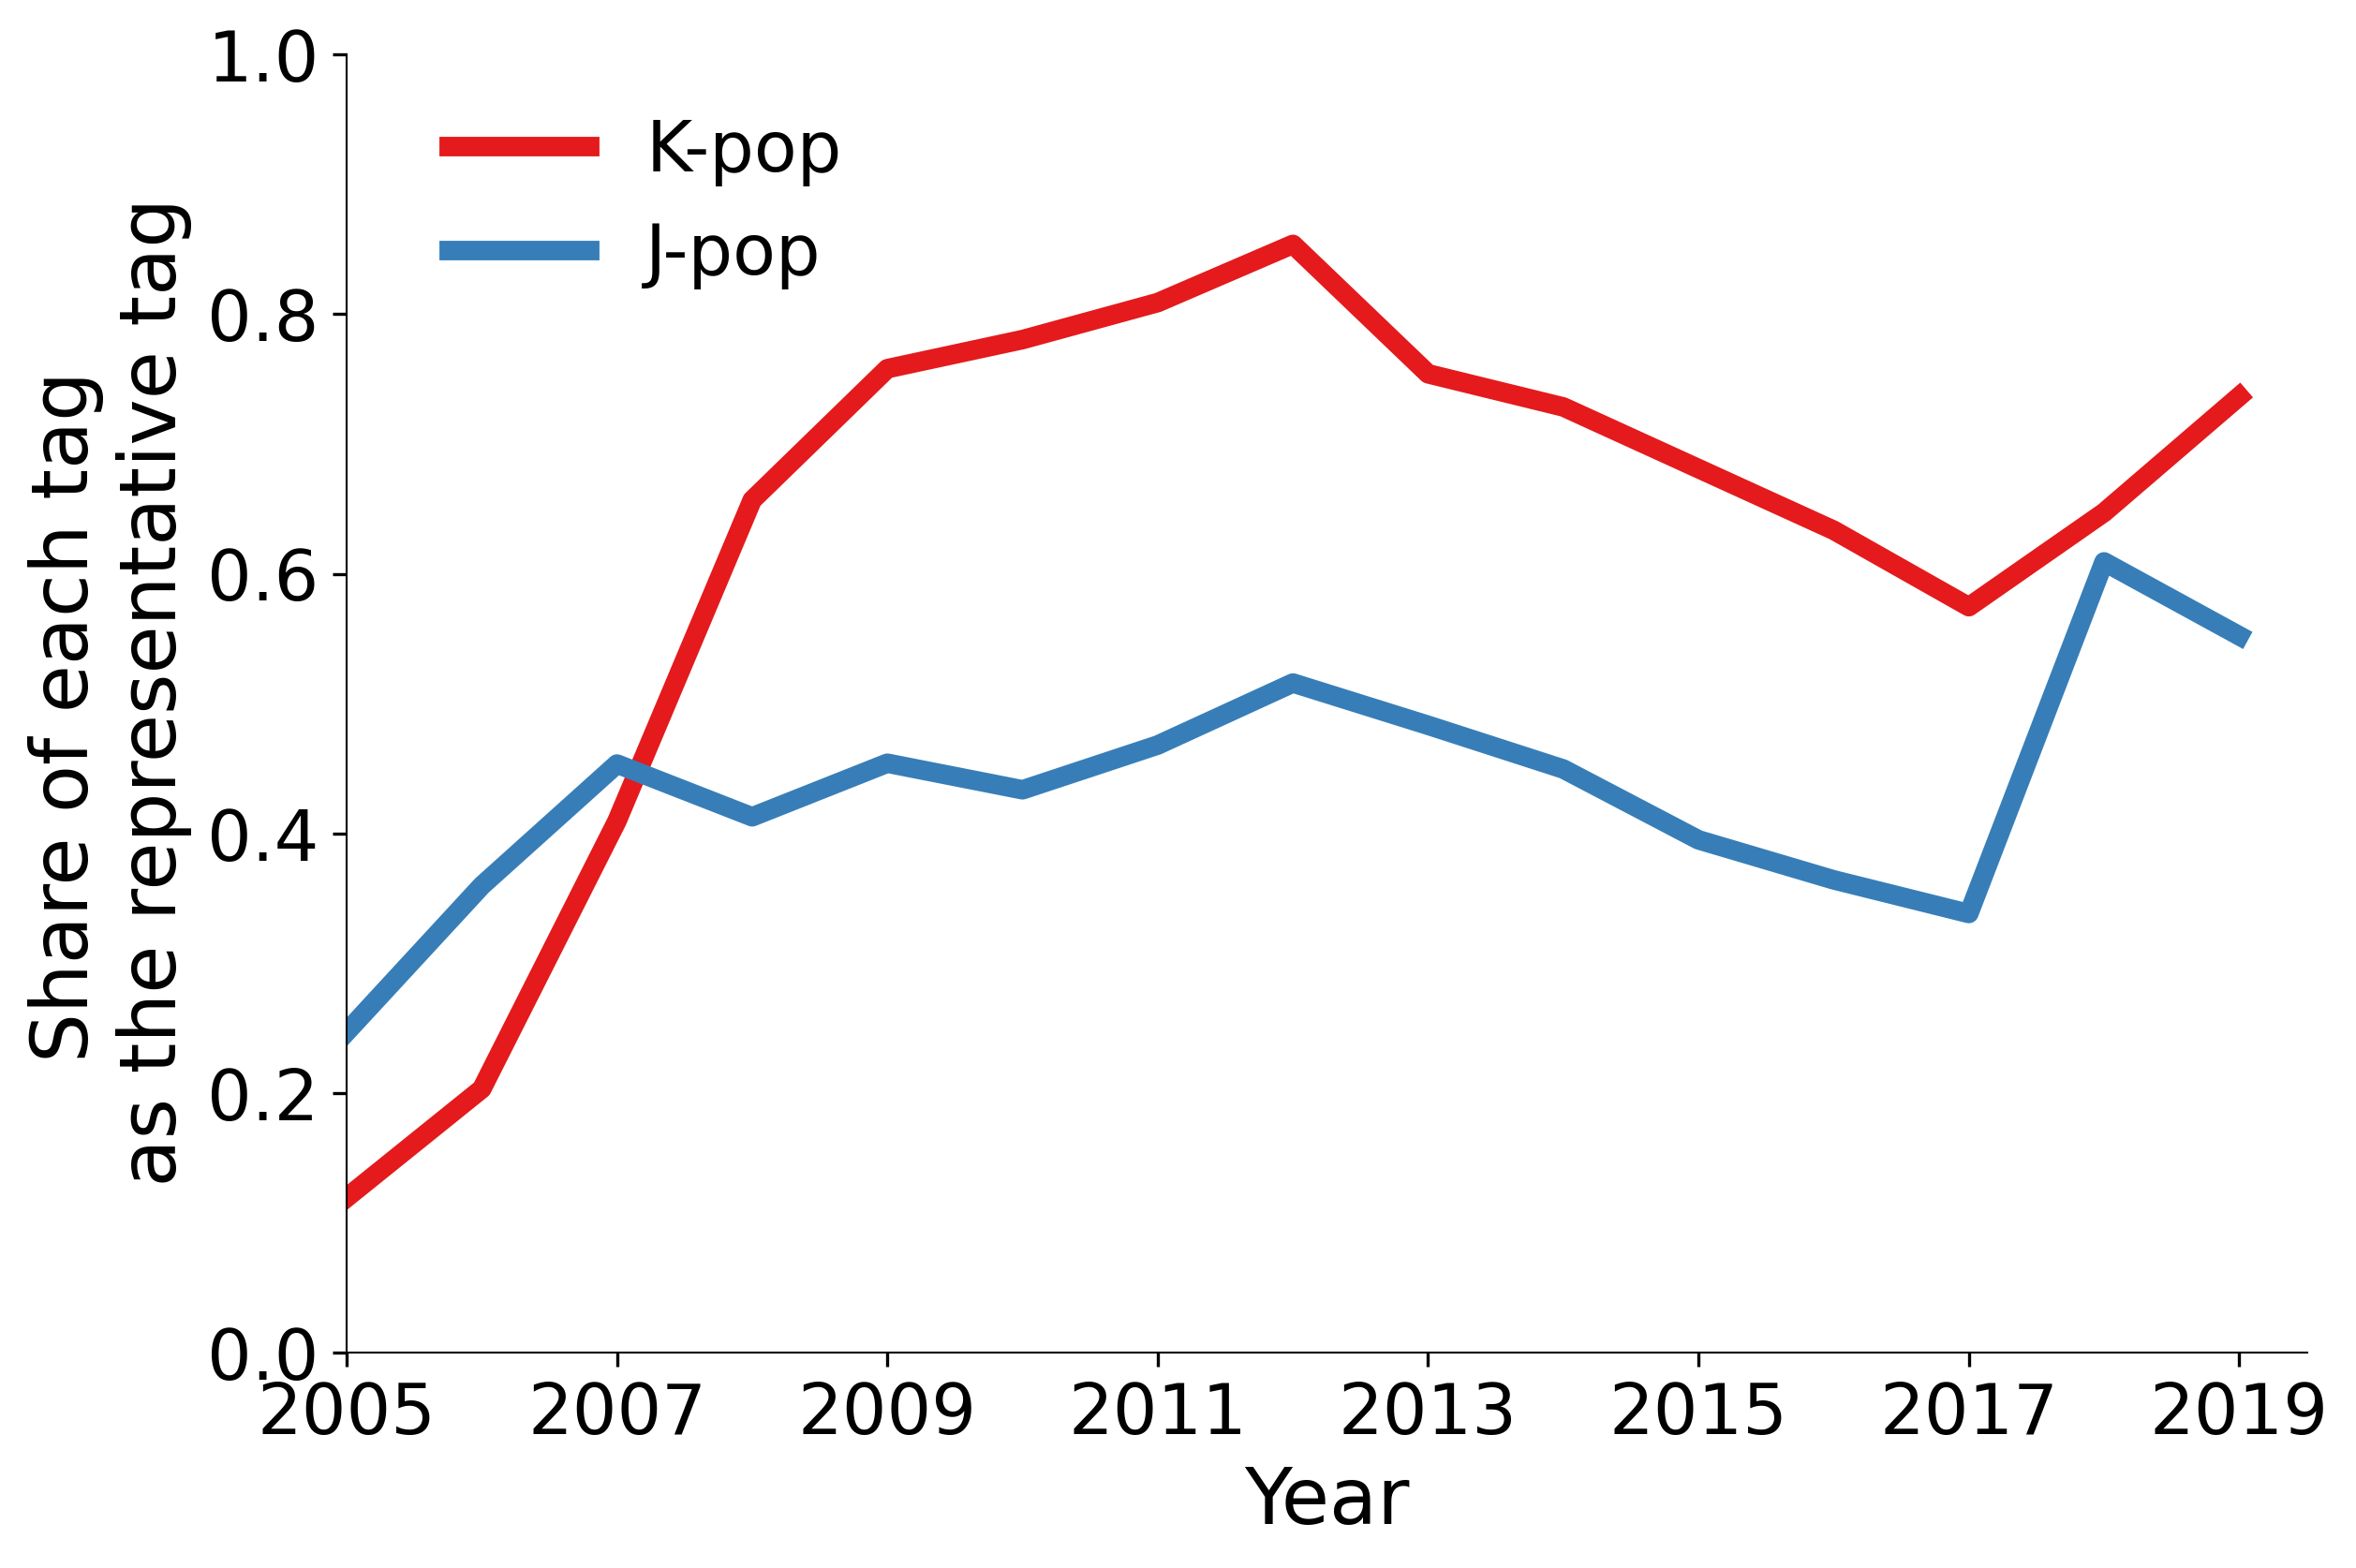

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['nature'])

fig, ax = plt.subplots(figsize=(9, 6))
# 軸設定
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(which='both', top=False, right=False, labelsize=18)
ax.yaxis.get_offset_text().set_fontsize(18)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Share of each tag \n as the representative tag", fontsize=20)
ax.ticklabel_format(style='plain', useOffset=False, axis='x')
ax.set_xticks(range(2005, 2020, 2))  # 2年ごとの目盛りに変更
ax.set_xlim(2005, 2019.5)
ax.set_ylim(bottom=0)  # y軸の下限を0に設定

df_rep_tag_rate_kpop = load_pickle("./pickle_data/df_rep_tag_rate_kpop.pkl")
ax.plot(df_rep_tag_rate_kpop, linewidth = 5, color = "#e41a1c", label = "K-pop")
df_rep_tag_rate_jpop = load_pickle("./pickle_data/df_rep_tag_rate_jpop.pkl")
ax.plot(df_rep_tag_rate_jpop, linewidth=5, color = "#377eb8", label = "J-pop")

# 凡例
ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.02, 1.0),  # グラフ内左上の少し内側 (x, y)
    fontsize=18,
    frameon=False
)

#plt.savefig("top_tag_rate.pdf")
plt.show()